# PMEmo Dataset - Feed Forward Neural Network
## Essentia Best Overall openSMILE eGeMAPS Featureset

## Import relevant libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import sys
sys.path.insert(1, '../../utils')
from paths import *

## Neural Network Training

### Import annotations dataset

In [2]:
df_annotations = pd.read_csv(get_pmemo_path('processed/annotations/pmemo_static_annotations.csv'))
df_annotations

,song_id,valence_mean_mapped,arousal_mean_mapped
0,1,0.150,-0.200
1,4,-0.425,-0.475
2,5,-0.600,-0.700
3,6,-0.300,0.025
4,7,0.450,0.400
...,...,...,...
762,993,0.525,0.725
763,996,0.125,0.750
764,997,0.325,0.425
765,999,0.550,0.750


### Import the featureset

This is where you should change between normalised and standardised, and untouched featuresets!

In [3]:
df_essentia_best_overall_opensmile_egemaps = pd.read_csv(get_pmemo_path('processed/features/integrated/standardised_essentia_best_overall_opensmile_egemaps_features.csv'))

# drop Unnamed:0 column
df_essentia_best_overall_opensmile_egemaps = df_essentia_best_overall_opensmile_egemaps[df_essentia_best_overall_opensmile_egemaps.columns[1:]]

df_essentia_best_overall_opensmile_egemaps

,song_id,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,tonal.key_temperley.strength,rhythm.beats_loudness_band_ratio.mean_0,rhythm.beats_loudness_band_ratio.mean_1,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,1,-0.290830,-0.161553,-0.674310,-0.966508,-0.692188,-0.466809,-0.224314,-0.490847,-0.744314,...,-0.356517,0.241192,-1.078395,0.626061,0.381042,-0.336055,-0.374205,0.262637,-0.077513,-1.197473
1,4,2.148017,2.355089,6.176068,-0.692793,-0.875022,-2.504826,-2.346037,1.052759,-0.515532,...,-1.587073,-1.756907,2.595686,1.246634,-2.081171,0.077305,0.364584,13.929680,12.635127,1.014336
2,5,4.061978,3.102229,2.654601,0.480322,0.431641,0.529917,0.178117,1.201395,-0.649196,...,-1.341486,-0.316982,-0.350587,1.247192,-0.483298,-0.156962,-0.196903,0.509336,0.506650,0.425787
3,6,0.609811,1.478902,0.594623,-0.265029,-1.486659,-1.304917,-1.560061,1.129215,-0.547660,...,-1.876367,0.705660,-1.005747,0.560435,-0.939150,-0.438867,-0.422328,4.102221,3.583107,0.429337
4,7,-0.407720,-0.322652,-0.043632,0.343143,1.010394,0.710881,0.859542,1.536379,-0.715476,...,1.506562,-0.467269,-0.478589,0.347808,-0.244452,-0.097217,-0.183003,-0.546643,-0.583730,0.385611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,993,-0.341976,-0.376271,-0.184984,1.148765,0.172968,-0.030536,0.217640,-0.104210,1.736366,...,0.581939,0.317231,0.217800,-0.272794,0.346534,-0.296380,0.179435,0.009848,-0.110172,0.380340
763,996,0.208018,-0.004852,-0.227602,1.123782,0.880366,0.113897,0.233136,-1.932951,1.310770,...,0.708211,1.645550,0.171330,0.506390,0.734247,-0.376792,-0.392740,0.211598,0.131591,0.647410
764,997,-0.448361,-0.267697,-0.099497,-1.869459,0.089641,-0.349415,-0.176068,-0.148750,-0.310712,...,0.274327,1.052788,-0.688337,-0.036849,0.200898,-0.273511,-0.243128,0.080631,1.233979,0.387081
765,999,-0.296933,0.022632,0.258205,-1.921844,-0.625854,-0.779872,-0.526150,0.666036,-1.240647,...,-0.185980,1.193421,0.299434,-0.851040,0.757317,-0.403438,-0.260820,0.378455,2.290346,0.977870


In [4]:
df_essentia_best_overall_opensmile_egemaps.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 126 columns):
 #    Column                                          Dtype  
---   ------                                          -----  
 0    song_id                                         int64  
 1    lowlevel.melbands_kurtosis.mean                 float64
 2    lowlevel.melbands_skewness.mean                 float64
 3    lowlevel.spectral_energy.mean                   float64
 4    tonal.chords_strength.mean                      float64
 5    tonal.hpcp_entropy.mean                         float64
 6    tonal.key_edma.strength                         float64
 7    tonal.key_temperley.strength                    float64
 8    rhythm.beats_loudness_band_ratio.mean_0         float64
 9    rhythm.beats_loudness_band_ratio.mean_1         float64
 10   rhythm.beats_loudness_band_ratio.mean_2         float64
 11   rhythm.beats_loudness_band_ratio.mean_3         float64
 12   rhythm.beats_loudnes

Join both the featureset and annotation set together

In [5]:
df_essentia_best_overall_opensmile_egemaps_whole = pd.merge(df_essentia_best_overall_opensmile_egemaps, df_annotations, how='inner', on='song_id')
df_essentia_best_overall_opensmile_egemaps_whole = df_essentia_best_overall_opensmile_egemaps_whole.drop('song_id', axis=1)
df_essentia_best_overall_opensmile_egemaps_whole

,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,tonal.key_temperley.strength,rhythm.beats_loudness_band_ratio.mean_0,rhythm.beats_loudness_band_ratio.mean_1,rhythm.beats_loudness_band_ratio.mean_2,...,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,valence_mean_mapped,arousal_mean_mapped
0,-0.290830,-0.161553,-0.674310,-0.966508,-0.692188,-0.466809,-0.224314,-0.490847,-0.744314,0.149480,...,-1.078395,0.626061,0.381042,-0.336055,-0.374205,0.262637,-0.077513,-1.197473,0.150,-0.200
1,2.148017,2.355089,6.176068,-0.692793,-0.875022,-2.504826,-2.346037,1.052759,-0.515532,-0.154840,...,2.595686,1.246634,-2.081171,0.077305,0.364584,13.929680,12.635127,1.014336,-0.425,-0.475
2,4.061978,3.102229,2.654601,0.480322,0.431641,0.529917,0.178117,1.201395,-0.649196,-1.032420,...,-0.350587,1.247192,-0.483298,-0.156962,-0.196903,0.509336,0.506650,0.425787,-0.600,-0.700
3,0.609811,1.478902,0.594623,-0.265029,-1.486659,-1.304917,-1.560061,1.129215,-0.547660,-1.166668,...,-1.005747,0.560435,-0.939150,-0.438867,-0.422328,4.102221,3.583107,0.429337,-0.300,0.025
4,-0.407720,-0.322652,-0.043632,0.343143,1.010394,0.710881,0.859542,1.536379,-0.715476,-1.128256,...,-0.478589,0.347808,-0.244452,-0.097217,-0.183003,-0.546643,-0.583730,0.385611,0.450,0.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,-0.341976,-0.376271,-0.184984,1.148765,0.172968,-0.030536,0.217640,-0.104210,1.736366,-0.502120,...,0.217800,-0.272794,0.346534,-0.296380,0.179435,0.009848,-0.110172,0.380340,0.525,0.725
763,0.208018,-0.004852,-0.227602,1.123782,0.880366,0.113897,0.233136,-1.932951,1.310770,-0.198898,...,0.171330,0.506390,0.734247,-0.376792,-0.392740,0.211598,0.131591,0.647410,0.125,0.750
764,-0.448361,-0.267697,-0.099497,-1.869459,0.089641,-0.349415,-0.176068,-0.148750,-0.310712,-0.747041,...,-0.688337,-0.036849,0.200898,-0.273511,-0.243128,0.080631,1.233979,0.387081,0.325,0.425
765,-0.296933,0.022632,0.258205,-1.921844,-0.625854,-0.779872,-0.526150,0.666036,-1.240647,-1.225680,...,0.299434,-0.851040,0.757317,-0.403438,-0.260820,0.378455,2.290346,0.977870,0.550,0.750


#### Prepare dataframes for the neural network

Perform splitting of the dataframe into training and testing sets

In [6]:
features = df_essentia_best_overall_opensmile_egemaps.drop('song_id', axis=1)
features

,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,tonal.key_temperley.strength,rhythm.beats_loudness_band_ratio.mean_0,rhythm.beats_loudness_band_ratio.mean_1,rhythm.beats_loudness_band_ratio.mean_2,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,-0.290830,-0.161553,-0.674310,-0.966508,-0.692188,-0.466809,-0.224314,-0.490847,-0.744314,0.149480,...,-0.356517,0.241192,-1.078395,0.626061,0.381042,-0.336055,-0.374205,0.262637,-0.077513,-1.197473
1,2.148017,2.355089,6.176068,-0.692793,-0.875022,-2.504826,-2.346037,1.052759,-0.515532,-0.154840,...,-1.587073,-1.756907,2.595686,1.246634,-2.081171,0.077305,0.364584,13.929680,12.635127,1.014336
2,4.061978,3.102229,2.654601,0.480322,0.431641,0.529917,0.178117,1.201395,-0.649196,-1.032420,...,-1.341486,-0.316982,-0.350587,1.247192,-0.483298,-0.156962,-0.196903,0.509336,0.506650,0.425787
3,0.609811,1.478902,0.594623,-0.265029,-1.486659,-1.304917,-1.560061,1.129215,-0.547660,-1.166668,...,-1.876367,0.705660,-1.005747,0.560435,-0.939150,-0.438867,-0.422328,4.102221,3.583107,0.429337
4,-0.407720,-0.322652,-0.043632,0.343143,1.010394,0.710881,0.859542,1.536379,-0.715476,-1.128256,...,1.506562,-0.467269,-0.478589,0.347808,-0.244452,-0.097217,-0.183003,-0.546643,-0.583730,0.385611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,-0.341976,-0.376271,-0.184984,1.148765,0.172968,-0.030536,0.217640,-0.104210,1.736366,-0.502120,...,0.581939,0.317231,0.217800,-0.272794,0.346534,-0.296380,0.179435,0.009848,-0.110172,0.380340
763,0.208018,-0.004852,-0.227602,1.123782,0.880366,0.113897,0.233136,-1.932951,1.310770,-0.198898,...,0.708211,1.645550,0.171330,0.506390,0.734247,-0.376792,-0.392740,0.211598,0.131591,0.647410
764,-0.448361,-0.267697,-0.099497,-1.869459,0.089641,-0.349415,-0.176068,-0.148750,-0.310712,-0.747041,...,0.274327,1.052788,-0.688337,-0.036849,0.200898,-0.273511,-0.243128,0.080631,1.233979,0.387081
765,-0.296933,0.022632,0.258205,-1.921844,-0.625854,-0.779872,-0.526150,0.666036,-1.240647,-1.225680,...,-0.185980,1.193421,0.299434,-0.851040,0.757317,-0.403438,-0.260820,0.378455,2.290346,0.977870


In [7]:
targets = df_annotations.drop('song_id', axis=1)
targets

,valence_mean_mapped,arousal_mean_mapped
0,0.150,-0.200
1,-0.425,-0.475
2,-0.600,-0.700
3,-0.300,0.025
4,0.450,0.400
...,...,...
762,0.525,0.725
763,0.125,0.750
764,0.325,0.425
765,0.550,0.750


Perform 80-20 train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

Create tensors for X_train and X_test

In [9]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float64)

Create tensors for Y_train and Y_test

In [10]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64)

Define neural network parameters and instantitate neural network

In [11]:
input_size = 1
hidden_size = 20 
output_size = 2  # Output size for valence and arousal
learning_rate = 0.001
criterion = nn.MSELoss()

In [12]:
num_epochs = 197

Set a random seed to ensure consistent initial weights of the neural network

In [13]:
# Set the seed
seed = 42
torch.manual_seed(seed)

Define the neural network

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), 2)
        )

    def forward(self, x):
        return self.layers(x)

#### Training

Prepare input_train_data and target_train_labels

In [15]:
input_train_data = X_train_tensor.float()

# input_train_data = input_train_data.view(input_train_data.shape[1], -1)
print(input_train_data.shape)

target_train_labels = y_train_tensor

torch.Size([613, 125])


Training loop

In [16]:
def train_model(num_epochs):
  model = NeuralNetwork(input_size=input_train_data.shape[1])
  optimiser = optim.Adam(model.parameters(), lr=learning_rate)
  
  for epoch in range(num_epochs):
    optimiser.zero_grad()
    
    # forward pass
    output = model(input_train_data)

    # calculate loss
    loss = torch.sqrt(criterion(output.float(), target_train_labels.float()))

    # backward pass
    loss.backward()
    # update weights
    optimiser.step()

    print(f'Epoch {epoch + 1}, Loss: {math.sqrt(loss.item())}')

  print("Training completed.")
  return model

In [17]:
model = train_model(num_epochs)

Epoch 1, Loss: 0.686100988521456
Epoch 2, Loss: 0.6836033411715547
Epoch 3, Loss: 0.681266397751311
Epoch 4, Loss: 0.6789546391809081
Epoch 5, Loss: 0.6767653427695908
Epoch 6, Loss: 0.6745827029576537
Epoch 7, Loss: 0.6724111502567637
Epoch 8, Loss: 0.6702517039509635
Epoch 9, Loss: 0.668104369912875
Epoch 10, Loss: 0.6659674529164619
Epoch 11, Loss: 0.6638366764034547
Epoch 12, Loss: 0.6617903039070363
Epoch 13, Loss: 0.6599527982247705
Epoch 14, Loss: 0.6581059958674761
Epoch 15, Loss: 0.6562447547702979
Epoch 16, Loss: 0.6543741436782379
Epoch 17, Loss: 0.6524960688403157
Epoch 18, Loss: 0.6506524919167118
Epoch 19, Loss: 0.648810130219449
Epoch 20, Loss: 0.6469672436757672
Epoch 21, Loss: 0.6451149580406218
Epoch 22, Loss: 0.6432527983078652
Epoch 23, Loss: 0.641436876502055
Epoch 24, Loss: 0.6396420311060983
Epoch 25, Loss: 0.6378333276827237
Epoch 26, Loss: 0.6362551774374522
Epoch 27, Loss: 0.6346829169749796
Epoch 28, Loss: 0.633102327074514
Epoch 29, Loss: 0.6315139822842853


## Neural Network Testing

Prepare input_test_data and target_test_labels

In [18]:
input_test_data = X_test_tensor.float()

# input_test_data = input_test_data.view(input_test_data.shape[1], -1)
print(input_test_data.shape)

target_test_labels = y_test_tensor

torch.Size([154, 125])


Generating scores

In [19]:
def test_model(trained_model):
  with torch.no_grad():
    test_pred = trained_model(input_test_data)
    test_loss = criterion(test_pred.float(), target_test_labels)

    # Separate the output into valence and arousal
    valence_pred = test_pred[:, 0]
    arousal_pred = test_pred[:, 1]
        
    valence_target = target_test_labels[:, 0]
    arousal_target = target_test_labels[:, 1]

     # Calculate RMSE for valence and arousal separately
    valence_rmse = math.sqrt(mean_squared_error(valence_pred, valence_target))
    arousal_rmse = math.sqrt(mean_squared_error(arousal_pred, arousal_target))

  rmse = math.sqrt(test_loss.item())
  print(f'Test RMSE: {rmse}')

  print(f'Valence RMSE: {valence_rmse}')
  print(f'Arousal RMSE: {arousal_rmse}')

  metric = R2Score(multioutput="raw_values")
  metric.update(test_pred, target_test_labels)
  adjusted_r2_score = metric.compute()
  print(f'Test R^2 score: {adjusted_r2_score}')

  metric = R2Score(multioutput="raw_values", num_regressors=input_test_data.shape[1])
  metric.update(test_pred, target_test_labels)
  adjusted_r2_score = metric.compute()
  print(f'Test Adjusted R^2 score: {adjusted_r2_score}')

  metric = R2Score()
  metric.update(test_pred, target_test_labels)
  r2_score = metric.compute()
  print(f'Test R^2 score (overall): {r2_score}')
  return test_pred, rmse, adjusted_r2_score, r2_score

In [20]:
test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)

Test RMSE: 0.23696983564517202
Valence RMSE: 0.2362627954839967
Arousal RMSE: 0.23767477249697086
Test R^2 score: tensor([0.4035, 0.5834], dtype=torch.float64)
Test Adjusted R^2 score: tensor([-2.2594, -1.2765], dtype=torch.float64)
Test R^2 score (overall): 0.49345080893975835


In [21]:
torch.save(model.state_dict(), '../../models/pmemo_feedforward_nn_essentia_best_overall_opensmile_egemaps_standardised.pt')

True values (test set)

In [22]:
target_test_labels

tensor([[-0.5750,  0.3500],
        [ 0.1250, -0.0250],
        [ 0.2000,  0.4750],
        [ 0.3500,  0.3500],
        [ 0.3000,  0.4500],
        [ 0.3500,  0.0250],
        [ 0.3250, -0.0250],
        [ 0.3750,  0.3500],
        [ 0.1500,  0.1000],
        [ 0.2750,  0.6500],
        [ 0.5000,  0.5250],
        [ 0.0500, -0.3500],
        [ 0.0500,  0.2250],
        [-0.3250, -0.4500],
        [-0.1000,  0.4500],
        [ 0.1250, -0.4000],
        [ 0.3750,  0.5500],
        [ 0.2000, -0.2250],
        [-0.4500, -0.3000],
        [ 0.0500,  0.0750],
        [ 0.2750,  0.4250],
        [-0.0250,  0.4000],
        [ 0.6500,  0.6750],
        [-0.1750, -0.3250],
        [-0.6500,  0.6500],
        [ 0.0250,  0.3000],
        [-0.0500,  0.6750],
        [-0.7250, -0.4500],
        [ 0.0000, -0.2750],
        [ 0.2750,  0.4500],
        [ 0.0000, -0.2000],
        [ 0.3250,  0.2250],
        [-0.3750, -0.1250],
        [-0.1000,  0.2250],
        [ 0.4000,  0.2250],
        [ 0.3500,  0

Predicted values

In [23]:
test_pred

tensor([[-1.1597e-01, -5.6545e-02],
        [-3.5494e-02,  1.4553e-02],
        [ 2.2348e-01,  2.7541e-01],
        [ 1.8985e-01,  2.3482e-01],
        [ 2.9555e-01,  3.6273e-01],
        [-1.1273e-01, -7.6566e-02],
        [ 1.1574e-01,  1.4745e-01],
        [ 3.9712e-01,  4.8580e-01],
        [-2.1829e-01, -4.2852e-01],
        [ 2.6744e-01,  3.2870e-01],
        [ 6.4124e-01,  7.8761e-01],
        [-1.2485e-01, -2.1101e-01],
        [-1.1235e-01, -7.8715e-02],
        [-1.9659e-01, -3.8550e-01],
        [-1.1493e-01, -6.1519e-02],
        [-1.2325e-01, -2.0608e-01],
        [ 5.1539e-01,  6.3121e-01],
        [-1.0687e-01, -1.3127e-01],
        [-1.3108e-01, -2.3022e-01],
        [ 3.9340e-01,  4.8139e-01],
        [ 2.8819e-01,  3.5384e-01],
        [-6.5299e-02, -5.7069e-03],
        [ 2.5791e-01,  3.1714e-01],
        [-1.9584e-01, -3.8401e-01],
        [-1.0817e-01, -3.6558e-02],
        [ 1.0316e-01,  1.3150e-01],
        [ 4.0536e-01,  4.9585e-01],
        [-1.2456e-01, -2.101

In [24]:
pred_valence = test_pred[:, 0]
pred_arousal = test_pred[1]
real_valence = target_test_labels[0]
real_arousal = target_test_labels[1]


metric = R2Score(multioutput='raw_values')
metric.update(test_pred, target_test_labels)
print(metric.compute())

tensor([0.4035, 0.5834], dtype=torch.float64)


## Analyse relationship between epochs and r^2 score

Create lists to store the epochs and R^2 scores

In [25]:
num_epochs_list = [i for i in range(1, 301)]
adjusted_r2_scores_valence_list = []
adjusted_r2_scores_arousal_list = []
r2_scores_list = []
rmse_list = []

Conduct training and testing for each num_epochs

In [26]:
for num_epochs in num_epochs_list:
  # Set the seed
  torch.manual_seed(seed)

  print(f'Num of epochs: {num_epochs}')
  
  model = train_model(num_epochs)

  print("Training completed.")
  print("Testing model...")

  test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)
  adjusted_r2_scores_valence_list.append(adjusted_r2_score[0])
  adjusted_r2_scores_arousal_list.append(adjusted_r2_score[1])
  r2_scores_list.append(r2_score)
  rmse_list.append(rmse)

print("Completed.")

Num of epochs: 1
Epoch 1, Loss: 0.686100988521456
Training completed.
Training completed.
Testing model...
Test RMSE: 0.46354111627128786
Valence RMSE: 0.30591060786226637
Arousal RMSE: 0.5797925775183759
Test R^2 score: tensor([-7.1866e-06, -1.4792e+00], dtype=torch.float64)
Test Adjusted R^2 score: tensor([ -4.4643, -12.5468], dtype=torch.float64)
Test R^2 score (overall): -0.7395845858740607
Num of epochs: 2
Epoch 1, Loss: 0.686100988521456
Epoch 2, Loss: 0.6836033411715547
Training completed.
Training completed.
Testing model...
Test RMSE: 0.4602823813253709
Valence RMSE: 0.3059127541286153
Arousal RMSE: 0.5745756068426101
Test R^2 score: tensor([-2.1219e-05, -1.4347e+00], dtype=torch.float64)
Test Adjusted R^2 score: tensor([ -4.4644, -12.3042], dtype=torch.float64)
Test R^2 score (overall): -0.7173844762837202
Num of epochs: 3
Epoch 1, Loss: 0.686100988521456
Epoch 2, Loss: 0.6836033411715547
Epoch 3, Loss: 0.681266397751311
Training completed.
Training completed.
Testing model..

### Plot the graph to visualise the relationship between the evaluation metrics

Import relevant libraries

In [27]:
import matplotlib.pyplot as plt

#### RMSE vs. num_epochs

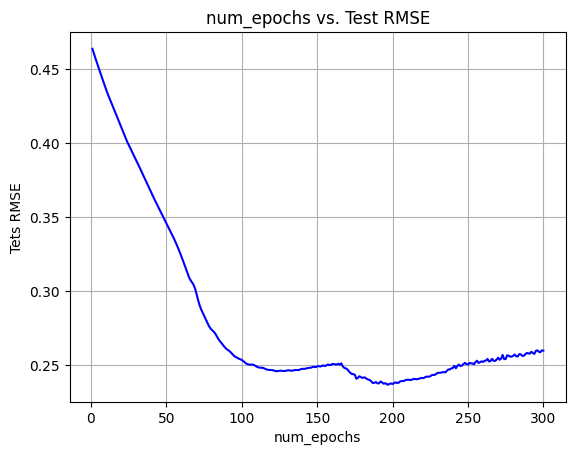

In [28]:
plt.plot(num_epochs_list, rmse_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test RMSE')
plt.xlabel('num_epochs')
plt.ylabel('Tets RMSE') 
plt.grid(True)
plt.show() 

In [29]:
min_rmse = min(rmse_list)
corresponding_r2_score = r2_scores_list[rmse_list.index(min_rmse)]
corresponding_num_epochs = num_epochs_list[rmse_list.index(min_rmse)]

print(f'Min RMSE score: {min_rmse}')
print(f'Corresponding R^2 SCore: {corresponding_r2_score}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Min RMSE score: 0.23696983564517202
Corresponding R^2 SCore: 0.49345080893975835
Corresponding num_epochs: 197


#### Test R^2 Score vs. num_epochs

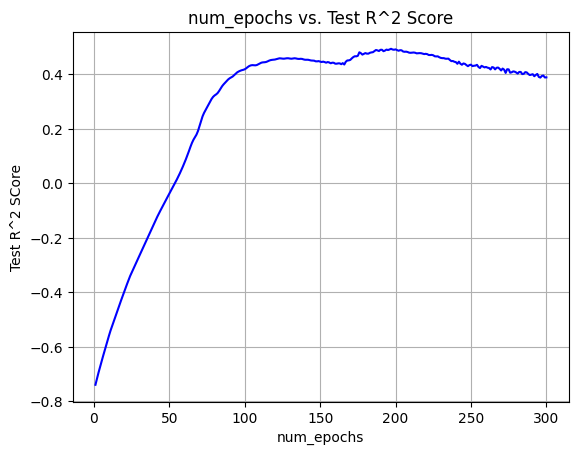

In [30]:
plt.plot(num_epochs_list, r2_scores_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test R^2 Score')
plt.xlabel('num_epochs')
plt.ylabel('Test R^2 SCore') 
plt.grid(True)
plt.show() 

In [31]:
max_r2_score = max(r2_scores_list)
corresponding_rmse = rmse_list[r2_scores_list.index(max_r2_score)]
corresponding_num_epochs = num_epochs_list[r2_scores_list.index(max_r2_score)]

print(f'Max R^2 score: {max_r2_score}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.49345080893975835
Corresponding RMSE: 0.23696983564517202
Corresponding num_epochs: 197


#### Test Adjsuted R^2 Score (Valence) vs. num_epochs

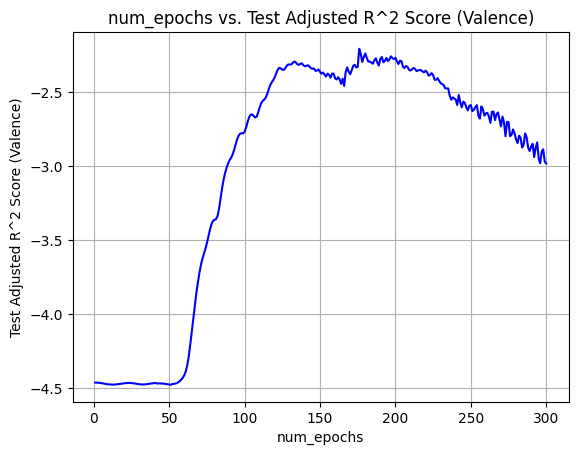

In [32]:
plt.plot(num_epochs_list, adjusted_r2_scores_valence_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Valence)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 Score (Valence)') 
plt.grid(True)
plt.show() 

In [33]:
max_r2_score_valence = max(adjusted_r2_scores_valence_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)]

print(f'Max R^2 score: {max_r2_score_valence}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: -2.2083983933756457
Corresponding RMSE: 0.24103703401494697
Corresponding num_epochs: 176


#### Test Adjusted R^2 Score (Arousal) vs. num_epochs

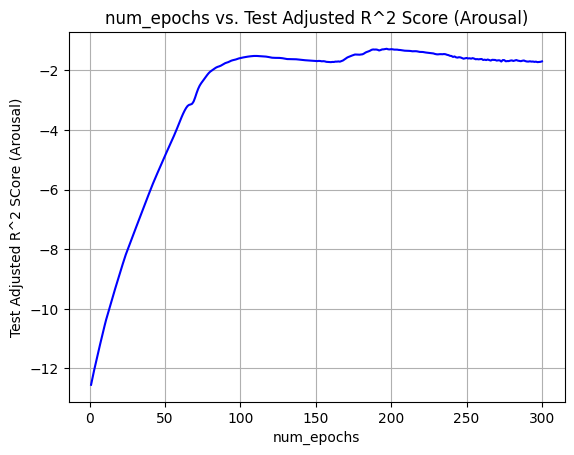

In [34]:
plt.plot(num_epochs_list, adjusted_r2_scores_arousal_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Arousal)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 SCore (Arousal)') 
plt.grid(True)
plt.show() 

In [35]:
max_r2_score_arousal = max(adjusted_r2_scores_arousal_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)]

print(f'Max R^2 score: {max_r2_score_arousal}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: -1.2764555498076806
Corresponding RMSE: 0.23696983564517202
Corresponding num_epochs: 197
